Class=1, n=39 (18.396%)
Class=4, n=11 (5.189%)
Class=0, n=112 (52.830%)
Class=3, n=27 (12.736%)
Class=2, n=23 (10.849%)


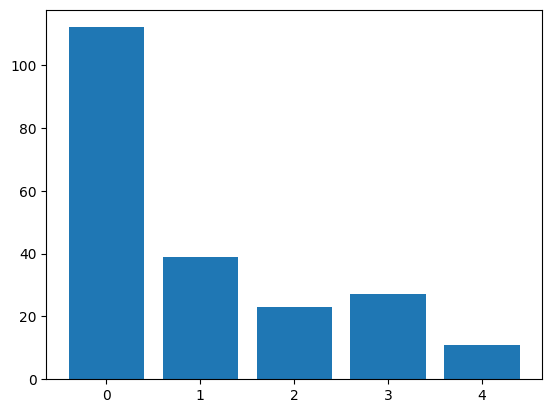

Before oversampling: Counter({0: 112, 1: 39, 3: 27, 2: 23, 4: 11})
After oversampling: Counter({1: 112, 4: 112, 0: 112, 3: 112, 2: 112})


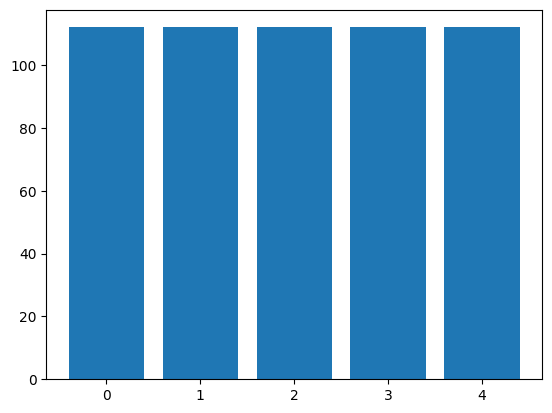

LR Accuracy: 0.5164835164835165
[[38  9  5  1  0]
 [ 5  4  2  4  0]
 [ 0  3  2  4  4]
 [ 0  1  0  3  4]
 [ 0  0  2  0  0]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        53
           1       0.24      0.27      0.25        15
           2       0.18      0.15      0.17        13
           3       0.25      0.38      0.30         8
           4       0.00      0.00      0.00         2

    accuracy                           0.52        91
   macro avg       0.31      0.30      0.30        91
weighted avg       0.60      0.52      0.55        91

Epoch 1/20


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 - 1s - 5ms/step - accuracy: 0.2222 - loss: 1.7787 - val_accuracy: 0.0536 - val_loss: 1.6905
Epoch 2/20
101/101 - 0s - 672us/step - accuracy: 0.2599 - loss: 1.6696 - val_accuracy: 0.0536 - val_loss: 1.8581
Epoch 3/20
101/101 - 0s - 652us/step - accuracy: 0.2758 - loss: 1.6356 - val_accuracy: 0.0536 - val_loss: 1.9023
Epoch 4/20
101/101 - 0s - 641us/step - accuracy: 0.2837 - loss: 1.6163 - val_accuracy: 0.0536 - val_loss: 1.9563
Epoch 5/20
101/101 - 0s - 636us/step - accuracy: 0.3056 - loss: 1.5952 - val_accuracy: 0.0536 - val_loss: 1.9716
Epoch 6/20
101/101 - 0s - 646us/step - accuracy: 0.3274 - loss: 1.5731 - val_accuracy: 0.0536 - val_loss: 1.8768
Epoch 7/20
101/101 - 0s - 704us/step - accuracy: 0.3294 - loss: 1.5526 - val_accuracy: 0.0536 - val_loss: 1.8380
Epoch 8/20
101/101 - 0s - 649us/step - accuracy: 0.3532 - loss: 1.5346 - val_accuracy: 0.0536 - val_loss: 1.8923
Epoch 9/20
101/101 - 0s - 637us/step - accuracy: 0.3690 - loss: 1.5144 - val_accuracy: 0.0536 - val_loss: 1.8

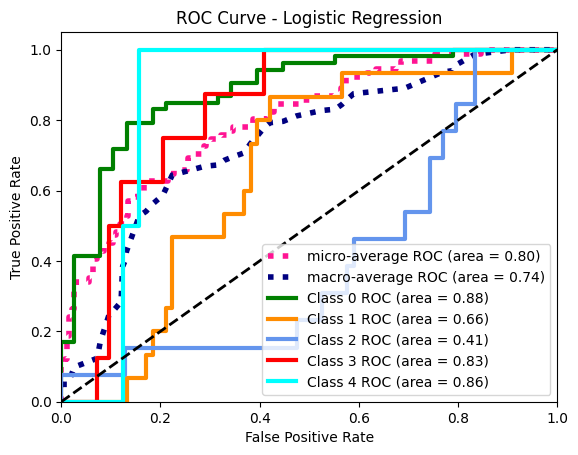

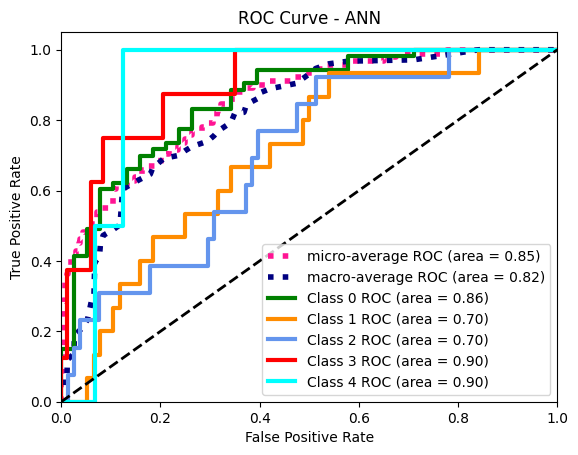

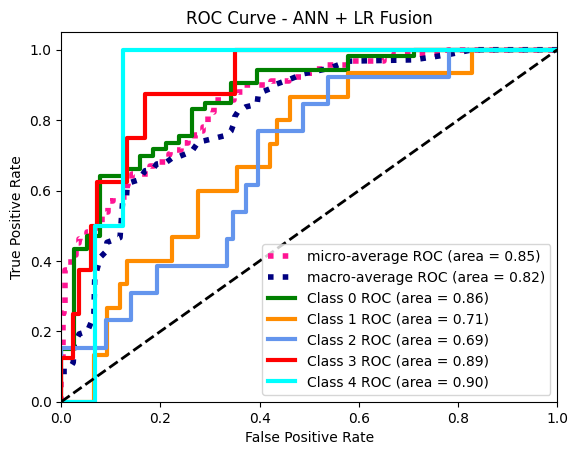

In [2]:
# Multi-class fusion model-2 (ANN+LR) using weighted score fusion
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from collections import Counter

# Load dataset
data = pd.read_csv("./multiclassification.csv")
X = data.iloc[:, 0:13].values
y = data.iloc[:, 13].values

# Train-test split (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Summarize class distribution
counter = Counter(y_train)
for k, v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

# Oversampling
os = RandomOverSampler()
X_train_ns, y_train_ns = os.fit_resample(X_train, y_train)

print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_ns))

counter = Counter(y_train_ns)
plt.bar(counter.keys(), counter.values())
plt.show()

X_train = X_train_ns
y_train = y_train_ns

# Standard & MinMax scalers
sc = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))

# --- Logistic Regression ---
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
model_lr = LogisticRegression(C=0.1, max_iter=500)
model_lr.fit(X_train_scaled, y_train)

y_pred_lr = model_lr.predict(X_test_scaled)
predictions_lr = model_lr.predict_proba(X_test_scaled)

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# --- ANN ---
model_ann = Sequential()
model_ann.add(Dense(8, input_dim=13, activation='relu', kernel_regularizer='l2'))
model_ann.add(Dense(5, activation='softmax'))
model_ann.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

X_train_ann = scaler.fit_transform(X_train)
X_test_ann = scaler.transform(X_test)

history = model_ann.fit(X_train_ann, y_train, validation_split=0.1, batch_size=5, epochs=20, shuffle=True, verbose=2)
predictions_ann = model_ann.predict(X_test_ann)
y_pred_ann = np.argmax(predictions_ann, axis=1)

print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print(confusion_matrix(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann))

# --- Weighted fusion ---
p_values = np.arange(1.0, 0, -0.05)
best_score = 0
best_p = 0
best_out = None

for p in p_values:
    q = 1 - p
    mixed = predictions_lr * p + predictions_ann * q
    out = np.argmax(mixed, axis=1)
    score = accuracy_score(y_test, out)
    print(f"Fusion Accuracy | p={p:.2f}, q={q:.2f}: {score:.4f}")
    if score > best_score:
        best_score = score
        best_p = p
        best_out = out

# Use best p
p = best_p
q = 1 - p
mixed = predictions_lr * p + predictions_ann * q
out = np.argmax(mixed, axis=1)
print("Final Fusion Accuracy:", accuracy_score(y_test, out))
print(confusion_matrix(y_test, out))
print(classification_report(y_test, out))

# --- ROC curves ---
n_classes = 5
y_test_bin = label_binarize(y_test, classes=range(n_classes))

def plot_multiclass_roc(y_test_bin, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4, color='deeppink', label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})')
    plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4, color='navy', label=f'macro-average ROC (area = {roc_auc["macro"]:.2f})')

    colors = cycle(['green', 'darkorange', 'cornflowerblue','red','aqua'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3, label=f'Class {i} ROC (area = {roc_auc[i]:.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC for each model and fusion
plot_multiclass_roc(y_test_bin, predictions_lr, "ROC Curve - Logistic Regression")
plot_multiclass_roc(y_test_bin, predictions_ann, "ROC Curve - ANN")
plot_multiclass_roc(y_test_bin, mixed, "ROC Curve - ANN + LR Fusion")
